<a href="https://colab.research.google.com/github/zoetice/data-science/blob/main/Zoe_TiceU5proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **What is the relationship between fish weight and fish length?**

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import xarray as xr
import pymc as pm
import graphviz as gv

from scipy.interpolate import PchipInterpolator

# Context
Fish are often priced for sale based on length or weight. Since a single fish can only have one price, I'm trying to find if the length and weight of fish usually have a linear relationship (and therefore should give the same price comparisson)

# DATA

**The first DATA set I tried was mostly linear but topped off so I decided against it**

In [ ]:
#load the data into a pandas dataframe, and print it
url_calihomes = 'https://raw.githubusercontent.com/zoetice/data-science/refs/heads/main/housing%5B1%5D%20-%20housing%5B1%5D.csv'
#I could have put the url string directly into pd.read_csv()
calihomes = pd.read_csv(url_calihomes)

In [ ]:
calihomes

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41,880,129.0,322,126,8.3252,452600,NEAR BAY
1,-122.22,37.86,21,7099,1106.0,2401,1138,8.3014,358500,NEAR BAY
2,-122.24,37.85,52,1467,190.0,496,177,7.2574,352100,NEAR BAY
3,-122.25,37.85,52,1274,235.0,558,219,5.6431,341300,NEAR BAY
4,-122.25,37.85,52,1627,280.0,565,259,3.8462,342200,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25,1665,374.0,845,330,1.5603,78100,INLAND
20636,-121.21,39.49,18,697,150.0,356,114,2.5568,77100,INLAND
20637,-121.22,39.43,17,2254,485.0,1007,433,1.7000,92300,INLAND
20638,-121.32,39.43,18,1860,409.0,741,349,1.8672,84700,INLAND


<Axes: xlabel='median_income', ylabel='median_house_value'>

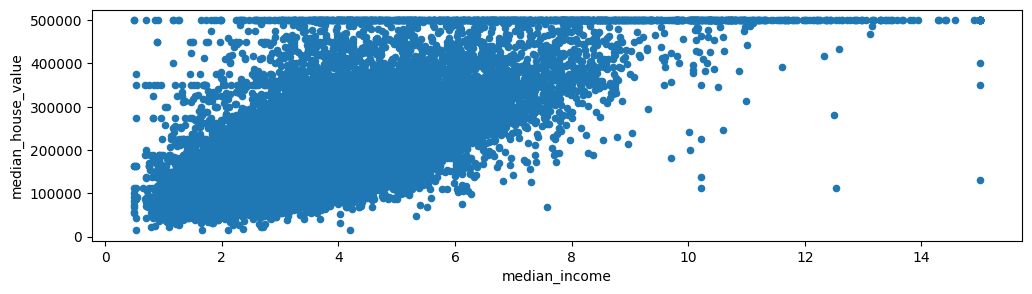

In [ ]:
calihomes.plot(x="median_income", y="median_house_value", figsize=(12, 3), kind="scatter")

**The next set I tried is the fish DATA set, which I ended up using**

In [ ]:
#load the data into a pandas dataframe, and print it
url_fish = 'https://media.geeksforgeeks.org/wp-content/uploads/20240522154350/Fish%5B1%5D.csv'
#I could have put the url string directly into pd.read_csv()
fish = pd.read_csv(url_fish)

In [ ]:
fish

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340
...,...,...,...,...,...,...,...
154,Smelt,12.2,11.5,12.2,13.4,2.0904,1.3936
155,Smelt,13.4,11.7,12.4,13.5,2.4300,1.2690
156,Smelt,12.2,12.1,13.0,13.8,2.2770,1.2558
157,Smelt,19.7,13.2,14.3,15.2,2.8728,2.0672


<Axes: xlabel='Weight', ylabel='Length1'>

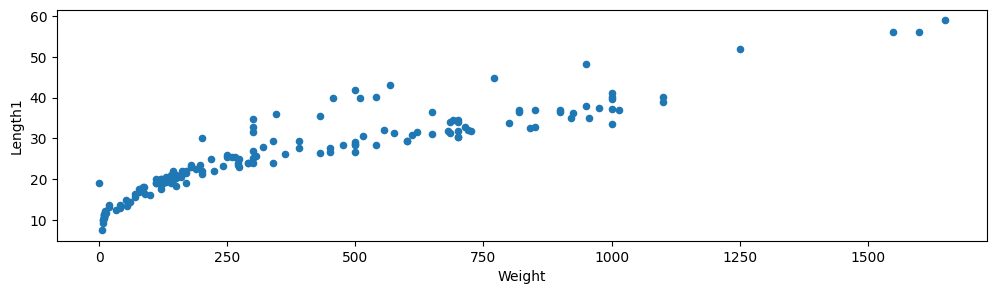

In [ ]:
fish.plot(x="Weight", y="Length1", figsize=(12, 3), kind="scatter")

# Posteriors and Linear Regressions

**The plotted out DATA looks mostly linear so I started trying to find a good linear regression**

In [ ]:

with pm.Model() as model_fish:

    #priors for the linear part of our model
    α = pm.Normal("α", mu=0, sigma=100)
    β = pm.Normal("β", mu=0, sigma=10)

    #this is the linear part of our model
    μ = pm.Deterministic("μ", α + β * fish.Weight)

    #prior for the standard deviation of our likelihood
    #Cauchy is a T dist with nu = 1
    σ = pm.HalfCauchy("σ", 10)

    #likelihood
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=fish.Length1)

    #inference data object
    idata_fish = pm.sample()

Text(0, 0.5, 'Length')

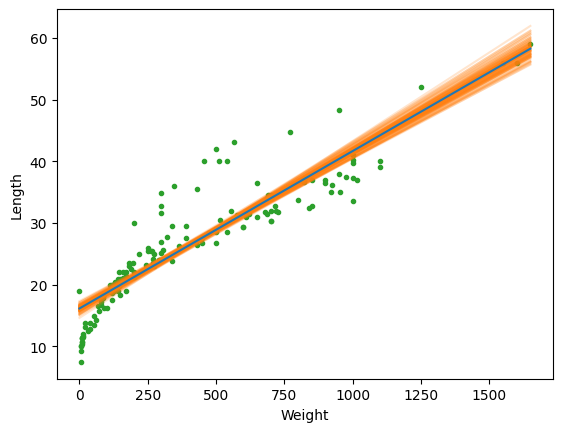

In [ ]:
posterior = az.extract(idata_fish, num_samples=100)

# grabbing x values for graphing.
x_plot = xr.DataArray(
    np.linspace(fish.Weight.min(), fish.Weight.max(), 50),
    dims="plot_fish"
    )

# this creates the expected line
mean_line = posterior["α"].mean() + posterior["β"].mean() * x_plot

#These are a 50 lines that our model came up with
lines = posterior["α"] + posterior["β"] * x_plot

#set up plot
fig, ax = plt.subplots()

#plots 50 other lines our model came up with.
ax.plot(x_plot, lines.T, c="C1", alpha=0.2, label="lines")

#plots the mean line
ax.plot(x_plot, mean_line, c="C0", label="mean line")

#plot the raw data
ax.plot(fish.Weight, fish.Length1, "C2.", zorder=-3)

#label axes and create legend
ax.set_xlabel("Weight")
ax.set_ylabel("Length")

In [ ]:
pm.sample_posterior_predictive(idata_fish, model=model_fish,  extend_inferencedata=True)

Text(0, 0.5, 'Length')

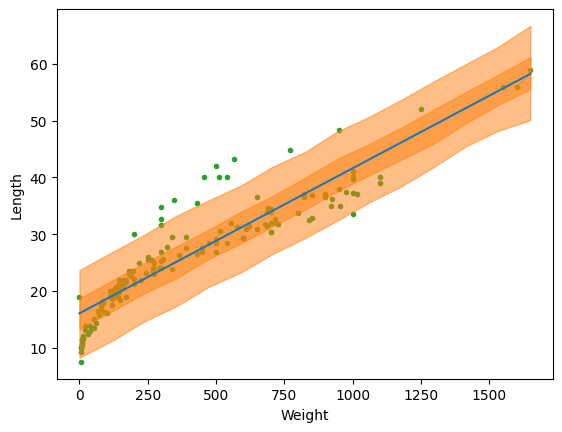

In [ ]:

#plots the posterior predictive distribution

#grabs the expected line, or line of best fit formula
mean_line = idata_fish.posterior["μ"].mean(("chain", "draw"))

# Get unique and sorted x-values for the interpolator to avoid 'not strictly increasing' error
unique_sorted_weights, unique_indices = np.unique(fish.Weight.values, return_index=True)

# creates some x values to run through our line formula (uses original fish.Weight range)
x = np.linspace(fish.Weight.min(), fish.Weight.max(), 15)

#grabs the 94% HDI and 50% HDI
y_pred_q = idata_fish.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
#sets up the HDIs for graphing
y_hat_bounds = iter(
    [
        PchipInterpolator(
            unique_sorted_weights,
            y_pred_q[i].values[unique_indices] # Use y-values corresponding to unique sorted x-values
        )(x)
        for i in range(4)
    ]
)

#plots raw data and our line of best fit
_, ax = plt.subplots()
ax.plot(fish.Weight, fish.Length1, "C2.", zorder=-3)
# Plot mean line using sorted original weights and corresponding mean_line values
ax.plot(fish.Weight.values[np.argsort(fish.Weight.values)], mean_line.values[np.argsort(fish.Weight.values)], c="C0")


#graphs the 94% and 50% HDIs
for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)

#labels
ax.set_xlabel("Weight")
ax.set_ylabel("Length")

<Axes: xlabel='y_pred'>

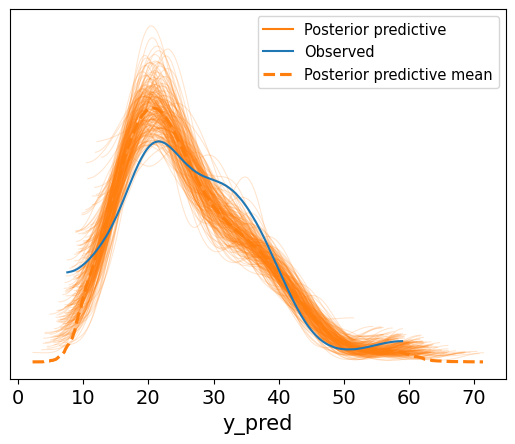

In [ ]:
az.plot_ppc(idata_fish, num_pp_samples=200, colors=["C1", "C0", "C1"])

**This posterior predictive was good but didnt have the starting curve**

In [ ]:
with pm.Model() as model_fish:

    #priors for our mean line
    α = pm.Normal("α", sigma=10)
    β = pm.Normal("β", sigma=10)

    #mean line
    μ = pm.Deterministic("μ", α + β * pm.math.sqrt(fish.Weight))

    #prior for standard deviation
    σ = pm.HalfNormal("σ", sigma = 10)

    #normal likelihood
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=fish.Length1)

    idata_fish = pm.sample()


In [ ]:
pm.sample_posterior_predictive(idata_fish, model=model_fish,  extend_inferencedata=True)

<Axes: xlabel='y_pred'>

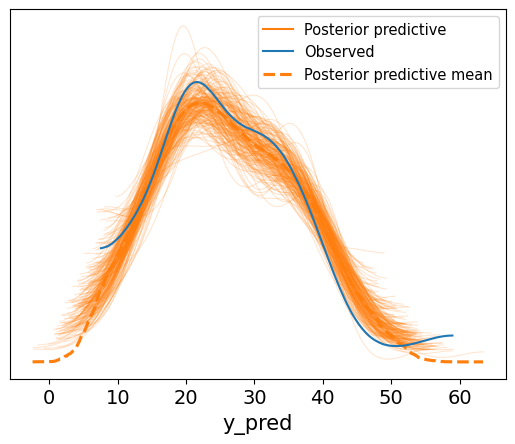

In [ ]:
az.plot_ppc(idata_fish, num_pp_samples=200, colors=["C1", "C0", "C1"])

Text(0, 0.5, 'fish length')

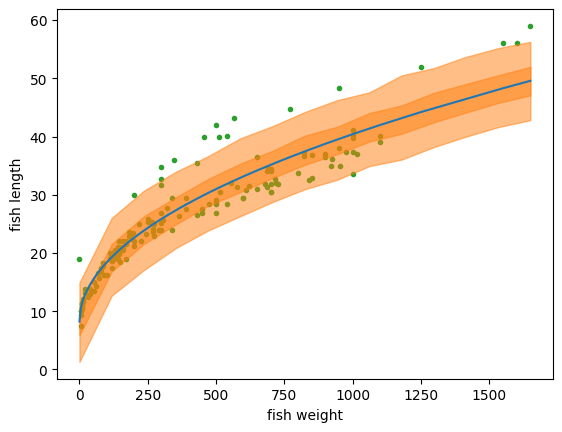

In [ ]:


mean_line = idata_fish.posterior["μ"].mean(("chain", "draw"))
Weight = np.random.normal(fish.Weight.values, 0.01)
idx = np.argsort(Weight)
x = np.linspace(Weight.min(), Weight.max(), 15)
y_pred_q = idata_fish.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(Weight[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

_, ax = plt.subplots()
ax.plot(fish.Weight, fish.Length1, "C2.", zorder=-3)
ax.plot(fish.Weight[idx], mean_line[idx], c="C0")

for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)

ax.set_xlabel("fish weight")
ax.set_ylabel("fish length")

In [ ]:
with pm.Model() as model_fish:

    #priors for line for our mean
    α = pm.Normal("α", sigma=10)
    β = pm.Normal("β", sigma=10)

    #priors for the line for our standard deviation
    γ = pm.HalfNormal("γ", sigma=10)
    δ = pm.HalfNormal("δ", sigma=10)

    #mean line
    μ = pm.Deterministic("μ", α + β * pm.math.sqrt(fish.Weight))

    #standard deviation line; this allows our variance to vary over th x values
    σ = pm.Deterministic("σ", γ + δ * fish.Weight)

    #normal likelihood
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=fish.Length1)

    idata_fish = pm.sample()

In [ ]:
pm.sample_posterior_predictive(idata_fish, model=model_fish,  extend_inferencedata=True)

Text(0, 0.5, 'fish length')

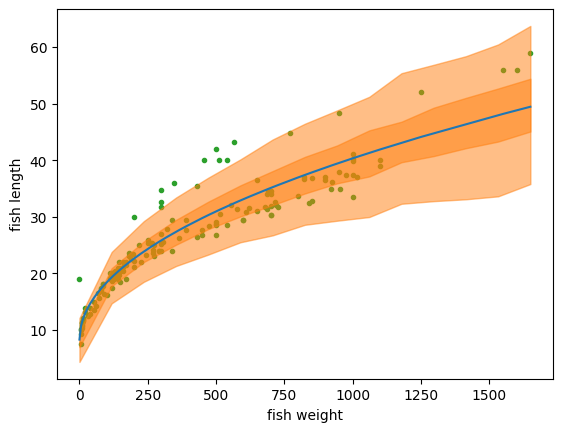

In [ ]:

mean_line = idata_fish.posterior["μ"].mean(("chain", "draw"))

#creates some x values to run through our line formula
Weight = np.random.normal(fish.Weight.values, 0.01)
idx = np.argsort(Weight)
x = np.linspace(Weight.min(), Weight.max(), 15)

#grabs the 94% HDI and 50% HDI
y_pred_q = idata_fish.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
#sets up the HDIs for graphing
y_hat_bounds = iter(
    [
        PchipInterpolator(Weight[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

#plots raw data and our line of best fit
_, ax = plt.subplots()
ax.plot(fish.Weight, fish.Length1, "C2.", zorder=-3)
ax.plot(fish.Weight[idx], mean_line[idx], c="C0")


#graphs the 94% and 50% HDIs
for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)
ax.set_xlabel("fish weight")
ax.set_ylabel("fish length")

**This posterior predictive is almost perfect :)**

# Conclusion
The weight of a fish and the length of a fish do for the most part have a linear relationship. This relationship makes pricing the fish easier as the bigger the fish, the bigger the price. Although linear, data points do get more spread out the heavier the fish is, while at first any fish between 0-15 inches were around the same weight.